In [135]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm
import pandas as pd
import warnings

In [136]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [137]:
warnings.filterwarnings('ignore')

In [138]:
experimentNum = 9
experimentIdx = 1
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [139]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [140]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [141]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=7, 
                                                                cutoff_high=30)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [142]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [143]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [144]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [145]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [146]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [147]:
len(CSP_passed_left_data)

25

In [148]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [149]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 1875)

In [150]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 1875)

In [151]:
m = 3

leftVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_left_data, 0, channelNum, minTrialsNum, m)
rightVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_right_data, 1, channelNum, minTrialsNum, m)
tongueVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_tongue_data, 2, channelNum, minTrialsNum, m)
footVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_foot_data, 3, channelNum, minTrialsNum, m)

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.653286,-3.009816,-3.314173,-3.031770,-3.324918,-3.125725,0
1,-3.605749,-2.987312,-3.305759,-3.075138,-3.282486,-3.115287,0
2,-3.851163,-3.151066,-3.586139,-3.085698,-3.290651,-3.106233,0
3,-3.635074,-3.123664,-3.463715,-3.112066,-3.276056,-3.112170,0
4,-3.714137,-2.995042,-3.437776,-2.998519,-3.334208,-3.096635,0
...,...,...,...,...,...,...,...
191,-3.758609,-2.406563,-3.512746,-2.990222,-3.321582,-3.102417,3
192,-3.886574,-2.899602,-3.677409,-3.019990,-3.246898,-3.066813,3
193,-3.859354,-3.114601,-3.554834,-3.030449,-3.319563,-3.088107,3
194,-3.990502,-2.732837,-3.604854,-3.090992,-3.288949,-3.097039,3


In [152]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,1.244883,-0.149356,2.025276,0.862713,-0.695827,-0.325831
1,1.774837,-0.039131,2.119916,-0.095598,0.206349,-0.043096
2,-0.961099,-0.841224,-1.033888,-0.328932,0.032763,0.202153
3,1.447916,-0.707007,0.343180,-0.911596,0.343061,0.041336
4,0.566504,-0.076991,0.634951,1.597481,-0.893349,0.462139
...,...,...,...,...,...,...
191,0.070712,2.805483,-0.208344,1.780829,-0.624890,0.305521
192,-1.355871,0.390492,-2.060524,1.123026,0.963015,1.269916
193,-1.052415,-0.662614,-0.681763,0.891905,-0.581960,0.693137
194,-2.514490,1.207334,-1.244402,-0.445932,0.068936,0.451189


In [153]:
n_componunts = 5
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [154]:
sum(PCA.explained_variance_ratio_())

0.9804158881138021

In [155]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, principalDF, labelDF, cv = 5)

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, principalDF, labelDF, cv = 5)

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.37269230769230766
교차검증 평균:  0.41346153846153844


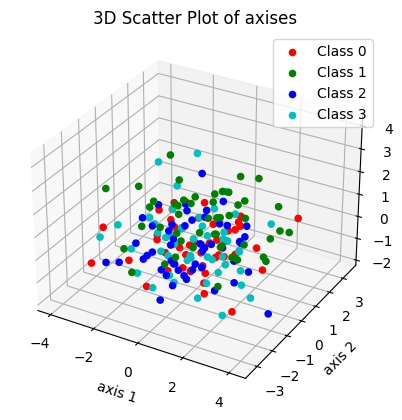

,axis1,axis2,axis3,axis4,axis5,label
0,0.410185,2.202072,-0.420888,-1.232875,-0.510817,0
1,0.238757,2.592809,-0.891357,-0.208946,0.213968,0
2,-0.180572,-1.609658,-0.463183,0.102313,-0.010103,0
3,0.206063,0.930890,-1.334777,0.934157,-0.140556,0
4,-0.543896,0.901718,0.262843,-1.295371,-1.197978,0
...,...,...,...,...,...,...
191,-0.557193,0.838186,3.141442,-0.456840,-0.621177,3
192,-2.159068,-1.960029,1.197740,0.303949,-0.073794,3
193,-0.704388,-1.306562,0.062885,-1.005708,-0.633389,3
194,-0.102712,-2.308215,1.649475,-0.087194,1.184970,3


In [156]:
# 데이터를 DataFrame으로 생성
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(data=df, num_of_classes=4)
df

In [157]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [158]:
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [159]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [160]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.4288461538461538
교차검증 평균:  0.3828205128205128
